# Testing

---
Stuff that i dont want to confuse in the Main

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import sys
ROOT_PATH = Path("..")  
sys.path.append(str(ROOT_PATH))
from src.dataloaders import get_dataloaders
from src.model import EfficientNetSpectrogram
from src.model import BaselineCNN

In [3]:
AUDIO_DIR = ROOT_PATH / "Data" / "Audio"
ANNOT_DIR = ROOT_PATH / "Data" / "Annotations"
SPECT_DIR = ROOT_PATH / "Data" / "Spectrograms"

ANNOT_FILE = ANNOT_DIR / "audio_annotations.csv"

train_df = pd.read_csv(ANNOT_DIR / "train.csv")
val_df   = pd.read_csv(ANNOT_DIR / "val.csv")
test_df  = pd.read_csv(ANNOT_DIR / "test.csv")

## Code

NorthernRightWhale ---  shape: (1, 128, 222)
Short_Finned(Pacific)PilotWhale ---  shape: (1, 128, 273)
Beluga_WhiteWhale ---  shape: (1, 128, 203)


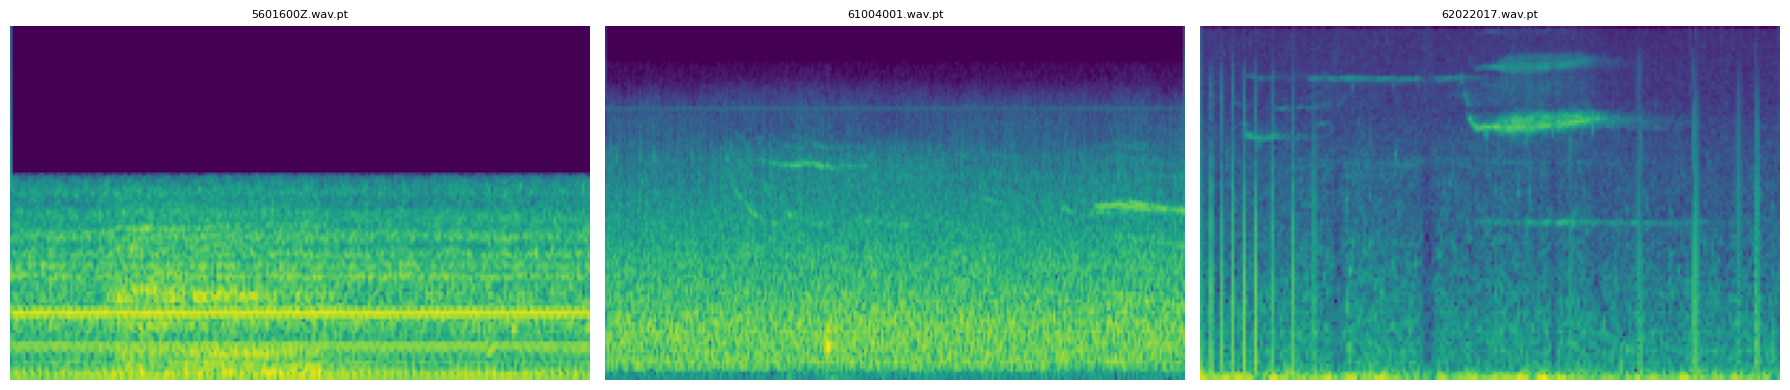

In [4]:
base_dir = ROOT_PATH / "Data" / "Spectrograms" / "train"

all_files = []
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith(".pt"):
            relative_path = os.path.join(root, f)
            all_files.append(relative_path)

if len(all_files) < 3:
    raise ValueError("Not enough .pt files found.")

# Select 3 random spectrograms
samples = random.sample(all_files, 3)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, path in zip(axes, samples):
    tensor = torch.load(path)

    species_name = os.path.basename(os.path.dirname(path))
    # Print the tensor shape and name
    print(f"{species_name} ---  shape: {tuple(tensor.shape)}")

    # Convert tensor to 2D for plotting
    if tensor.dim() == 2:
        img = tensor
    elif tensor.dim() == 3:
        # assume [C, H, W]
        img = tensor[0]  
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

    ax.imshow(img.numpy(), aspect="auto", origin="lower", cmap="viridis")
    ax.set_title(os.path.basename(path), fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

## CNN

**Dataloader**

In [5]:
SPEC_ROOT = ROOT_PATH / "Data" / "Spectrograms"

train_loader, val_loader, test_loader = get_dataloaders(
    SPEC_ROOT,
    batch_size=16
)

### Testing basic cnn

In [6]:
# Ensure train_loader exists (create if not)
try:
	class_names
except NameError:
	class_names = sorted(train_df['category'].unique())

NUM_CLASSES = len(class_names)
# Get one batch
x, y = next(iter(train_loader))

print("Input batch shape:", x.shape)
print("Labels shape:", y.shape)

# CREATE MODEL WITH 44 CLASSES
baseline = BaselineCNN(input_channels=1, num_classes=NUM_CLASSES)

# Forward pass
with torch.no_grad():
    out = baseline(x)

print("Output shape:", out.shape)
#print("Output:", out)

Input batch shape: torch.Size([16, 1, 128, 400])
Labels shape: torch.Size([16])
Output shape: torch.Size([16, 44])


**For Human-readable probabilities:**

In [7]:
# probs = torch.softmax(out, dim=1)
# print(probs)

*Note: example: [-0.1171, -0.0087]*
- *Score for class 0: -0.1171*
- *Score for class 1: -0.0087*

*The class with the higher logit is the predicted class.*
- *Here: -0.0087 > -0.1171 → predict class 1.*

*We have 16 predictions (16 x 2 matrix)*

### Testing EfficientNet CNN

In [8]:
# ensure class_names exists (derive from train_df if not)
try:
	class_names
except NameError:
	class_names = sorted(train_df['category'].unique())

NUM_CLASSES = len(class_names)

model = EfficientNetSpectrogram(num_classes=NUM_CLASSES)

x, y = next(iter(train_loader))

x, y = next(iter(train_loader))

print("Input batch shape:", x.shape)
print("Labels shape:", y.shape)

out = model(x)

print("Output shape:", out.shape)
# print("Output:", out)

Input batch shape: torch.Size([16, 1, 128, 400])
Labels shape: torch.Size([16])
Output shape: torch.Size([16, 44])


**For Human-readable probabilities:**

In [9]:
# probs = torch.softmax(out, dim=1)
# print(probs)

We can see in this case that EfficientNet propability outcomes differ more from each sample, meaning it recognises more deep patterns than our basic cnn

### Testing output shapes of both models
same output shapes: perfect

In [10]:
print(f"Input shape:", x.shape, "\n")

out = model(x)
print(f"EfficientNet output shape:", out.shape, "\n")

out_base = baseline(x)
print("Baseline CNN output shape:", out_base.shape)

Input shape: torch.Size([16, 1, 128, 400]) 

EfficientNet output shape: torch.Size([16, 44]) 

Baseline CNN output shape: torch.Size([16, 44])


## Training

#### Single Training step
training one batch, to see of learing works:
- Forward pass → produce logits
- Loss computation → measure error
- Backward pass → compute gradients
- Optimizer step → update weights

only slight difference will be seen

In [11]:
# get one batch
x, y = next(iter(train_loader))
print("Input batch shape:", x.shape)
print("Labels shape:", y.shape)
model = BaselineCNN(input_channels=1, num_classes=NUM_CLASSES)
model.train()

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# forward pass
out = model(x)
loss = criterion(out, y)
print("Loss BEFORE backward:", loss.item())

optimizer.zero_grad()  # clear old gradients
loss.backward()         # compute new gradients 

# actual learning
optimizer.step()        # update weights

out_after = model(x)
loss_after = criterion(out_after, y)
print("Loss AFTER one update:", loss_after.item())

Input batch shape: torch.Size([16, 1, 128, 400])
Labels shape: torch.Size([16])
Loss BEFORE backward: 3.7980387210845947
Loss AFTER one update: 2.8776519298553467
